https://github.com/facebookresearch/Detectron

https://github.com/facebookresearch/detectron2

# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/SUNRGBD/train.json", "/content/drive/MyDrive/SUNRGBD/dataset/train/")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/SUNRGBD/test.json", "/content/drive/MyDrive/SUNRGBD/dataset/test/")

In [ ]:
from detectron2.data.datasets import load_coco_json

In [ ]:
dataset_dicts = load_coco_json("/content/drive/MyDrive/SUNRGBD/train.json", "/content/drive/MyDrive/SUNRGBD/dataset/train/", "my_dataset_train")

[05/08 05:53:17 d2.data.datasets.coco]: Loaded 5247 images in COCO format from /content/drive/MyDrive/SUNRGBD/train.json


In [ ]:
metadata = MetadataCatalog.get("my_dataset_train")

In [ ]:
img = cv2.imread("/content/drive/MyDrive/SUNRGBD/dataset/train/img-005008.jpg") 

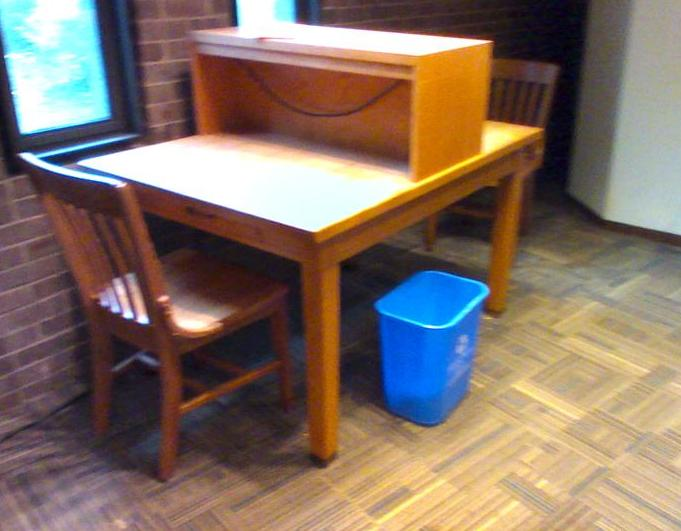

In [ ]:
cv2_imshow(img)

In [ ]:
from detectron2.utils.visualizer import ColorMode

In [ ]:
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)

In [ ]:
out = visualizer.draw_dataset_dict(dataset_dicts[0])   

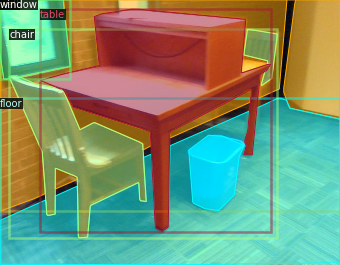

In [ ]:
cv2_imshow(out.get_image()[:, :, ::-1])

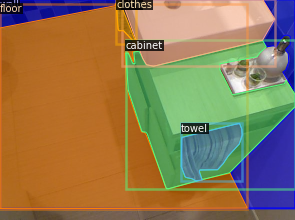

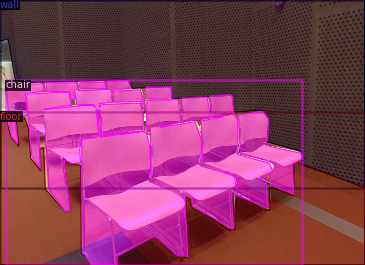

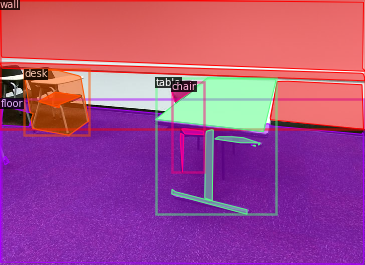

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 30000    
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 37  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[05/08 10:49:42 d2.data.datasets.coco]: Loaded 5020 images in COCO format from /content/drive/MyDrive/SUNRGBD/test.json
[05/08 10:49:42 d2.data.build]: Distribution of instances among all 37 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
|     wall      | 4640         |    floor    | 4400         |  cabinet   | 811          |
|      bed      | 522          |    chair    | 2996         |    sofa    | 624          |
|     table     | 2536         |    door     | 1296         |   window   | 1342         |
|   bookshelf   | 265          |   picture   | 850          |  counter   | 362          |
|    blinds     | 186          |    desk     | 829          |  shelves   | 195          |
|    curtain    | 460          |   dresser   | 225          |   pillow   | 547          |
|    mirror     | 334          |  floor_mat  | 36           |  clothes   | 38

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/SUNRGBD/output/model_final.pth")  # path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
im = cv2.imread("/content/drive/MyDrive/SUNRGBD/dataset/train/img-002500.jpg")

In [ ]:
outputs = predictor(im)

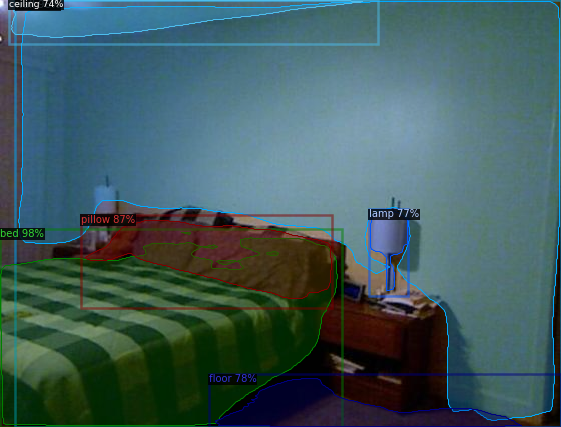

In [ ]:
from detectron2.utils.visualizer import ColorMode
v = Visualizer(im[:, :, ::-1], metadata=
               MetadataCatalog.get("my_dataset_val"), scale=1.0, 
                   instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

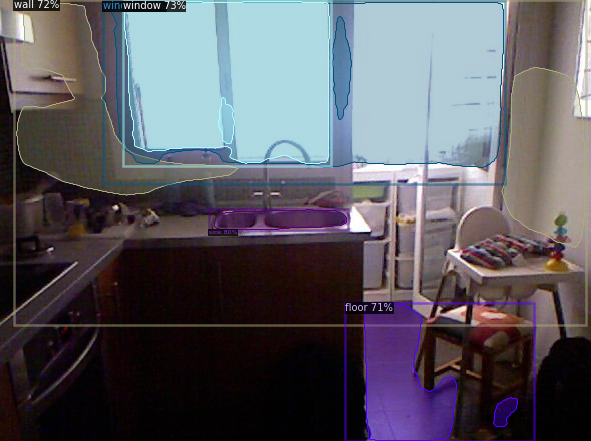

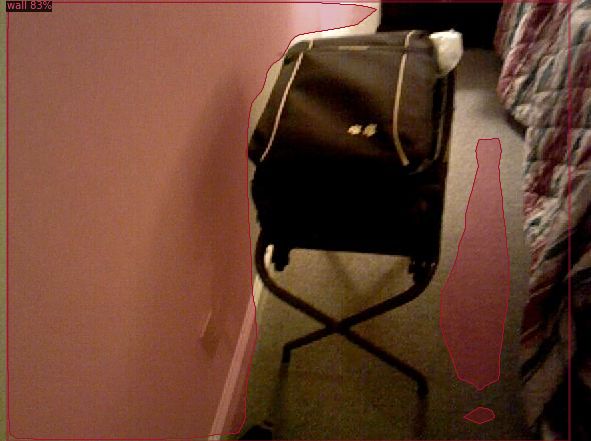

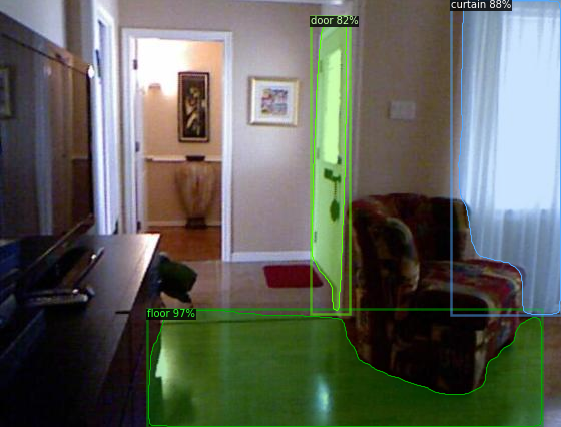

In [ ]:
from detectron2.utils.visualizer import ColorMode
images = os.listdir('/content/drive/MyDrive/SUNRGBD/dataset/test/')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1], metadata=
               MetadataCatalog.get("my_dataset_val"), scale=1.0, 
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# Image process

In [ ]:
'''
Guide for usage:
In your terminal, run the command:

python download_gdrive.py GoogleFileID /path/for/this/file/to/download/file.type

Credited to 
https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
author: https://stackoverflow.com/users/1475331/user115202
'''

import requests

from tqdm import tqdm

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
                        bar.update(CHUNK_SIZE)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

## COCO-InstanceSegmentation

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

Nagy felbontású kinti képek.

In [ ]:
if __name__ == "__main__":
    # TAKE ID FROM SHAREABLE LINK
    file_id = "1JDJZWtJf7ABN0U2JXNP3_M5xcGcb5ov6"
    # DESTINATION FILE ON YOUR DISK
    destination = "kepek.zip"
    download_file_from_google_drive(file_id, destination)    

In [ ]:
!unzip kepek.zip

In [ ]:
import os
images = os.listdir('/content/kepek/')

In [ ]:
!mkdir results

In [ ]:
for i in range(len(images)):
  im = cv2.imread("./kepek/"+images[i])
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2.imwrite("results/"+images[i],out.get_image()[:, :, ::-1])

In [ ]:
import shutil
shutil.make_archive("Images_high_resolution_Detectron2_mask_rcnn", 'zip', "/content/results")

A videóból elmentett képek.

In [ ]:
%cd /content/

In [ ]:
!mkdir images

In [ ]:
def saveImages(pathIn, pathOut):
    count = 0
    time = 1000
    videoCapture = cv2.VideoCapture(pathIn)
    success,image = videoCapture.read()
    success = True

    while success:
        videoCapture.set(cv2.CAP_PROP_POS_MSEC,(count*time))    
        success,image = videoCapture.read()
        if (success):
            cv2.imwrite(pathOut + "image%d.jpg" % count, image)     
        count += 1

In [ ]:
saveImages("/content/proba.mp4","/content/images/")

In [ ]:
images = os.listdir('/content/images/')

In [ ]:
!mkdir results2

In [ ]:
for i in range(len(images)):
    im = cv2.imread("./images/"+images[i])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("results2/"+images[i],out.get_image()[:, :, ::-1])

In [ ]:
import shutil

In [ ]:
shutil.make_archive("Images_from_video2_Detectron2_mask_rcnn", 'zip', "/content/results2")

https://www.imageclef.org/photodata

In [ ]:
!wget http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz

In [ ]:
!tar -xvzf /content/iaprtc12.tgz

In [ ]:
dirs = os.listdir('/content/iaprtc12/images/')

In [ ]:
os.mkdir('/content/iaprtc12_images/')

In [ ]:
for i in range(len(dirs)):
    os.mkdir('/content/iaprtc12_images/'+dirs[i])   

In [ ]:
delete_dir = []
for i in range(len(dirs)):
    original = '/content/iaprtc12/images/'+dirs[i]+'/'
    files = os.listdir(original)
    if (len(files)==0):
        delete_dir.append(dirs[i])

In [ ]:
for i in range(len(delete_dir)):
  dirs.remove(delete_dir[i])

In [ ]:
import shutil
for i in range(len(dirs)):
    original = '/content/iaprtc12/images/'+dirs[i]+'/'
    target = '/content/iaprtc12_images/'+dirs[i]+'/'
    files = os.listdir(original)

    for j in range(15):
        shutil.copyfile(original+files[j], target+files[j])

In [ ]:
os.mkdir('/content/results3')

In [ ]:
for i in range(len(dirs)):
  os.mkdir('/content/results3/'+dirs[i])

In [ ]:
for j in range(len(dirs)):
    images = os.listdir('/content/iaprtc12_images/'+dirs[j]+"/")

    for i in range(len(images)):
        im = cv2.imread("./iaprtc12_images/"+dirs[j]+"/"+images[i])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2.imwrite("results3/"+dirs[j]+"/"+images[i],out.get_image()[:, :, ::-1])

In [ ]:
shutil.make_archive("Images_iaprtc12_Detectron2_mask_rcnn", 'zip', "/content/results3")

## COCO-PanopticSegmentation

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

Nagy felbontású kinti képek.

In [ ]:
os.mkdir('/content/results4')

In [ ]:
images = os.listdir('/content/kepek7/')

In [ ]:
for i in range(len(images)):
    im = cv2.imread("./kepek7/"+images[i])
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    cv2.imwrite("results4/"+images[i],out.get_image()[:, :, ::-1])

In [ ]:
import shutil
shutil.make_archive("PanopticSegmentation_Images_high_resolution_Detectron2_mask_rcnn", 'zip', "/content/results4")

A videóból elmentett képek.

In [ ]:
os.mkdir('/content/results5')

In [ ]:
images = os.listdir('/content/images/')

In [ ]:
for i in range(len(images)):
    im = cv2.imread("./images/"+images[i])
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    cv2.imwrite("results5/"+images[i],out.get_image()[:, :, ::-1])

In [ ]:
import shutil
shutil.make_archive("PanopticSegmentation_Images_from_video2_Detectron2_mask_rcnn", 'zip', "/content/results5")

Iaprtc12 képek.

In [ ]:
os.mkdir('/content/results6')

In [ ]:
dirs = os.listdir('/content/iaprtc12/images/')

In [ ]:
delete_dir = []
for i in range(len(dirs)):
    original = '/content/iaprtc12/images/'+dirs[i]+'/'
    files = os.listdir(original)
    if (len(files)==0):
        delete_dir.append(dirs[i])

In [ ]:
for i in range(len(delete_dir)):
  dirs.remove(delete_dir[i])

In [ ]:
for i in range(len(dirs)):
  os.mkdir('/content/results6/'+dirs[i])

In [ ]:
for j in range(len(dirs)):
    images = os.listdir('/content/iaprtc12_images/'+dirs[j]+"/")

    for i in range(len(images)):
        im = cv2.imread("./iaprtc12_images/"+dirs[j]+"/"+images[i])
        panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
        cv2.imwrite("results6/"+dirs[j]+"/"+images[i],out.get_image()[:, :, ::-1])

In [ ]:
shutil.make_archive("PanopticSegmentation_Images_iaprtc12_Detectron2_mask_rcnn", 'zip', "/content/results6")